56
This choice will generate autonomous dynamics
No change  applied to TS or repr data


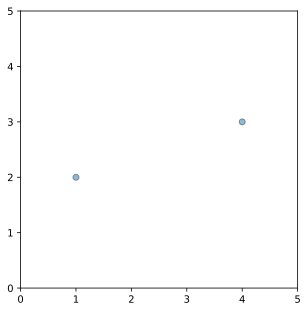

In [29]:
import torch
device = 'cpu'
import matplotlib.pyplot as plt
import numpy as np
from models.training import create_dataloader


# Juptyer magic: For export. Makes the plots size right for the screen 
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

%config InlineBackend.figure_formats = ['svg'] 

torch.backends.cudnn.deterministic = True
seed = np.random.randint(1,200)
seed = 56
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
print(seed)
g = torch.Generator()
g.manual_seed(seed)

# design choices 
chosen_problem = 'restricted_TS'
data_noise = 0.
n_different_weights = 1
if n_different_weights == 1:
    print('This choice will generate autonomous dynamics')
else:
    print('This choice generates non-autonomous dynamics, letting the weights depend on time')

possible_problem = {'moons':'moons', 'ToggleSwitch':'TS', 'repressilator':'repr', 'restricted_TS': 'restrictedTS'} 
# this choices determine the data set that we build and subsequent choices on the construction of the neural ODE 
# - in particular, it determines the dimensions 
problem = possible_problem[chosen_problem]

plotlim = [0, 5]

dataloader, dataloader_viz = create_dataloader(problem, batch_size = 2, noise = data_noise, 
                                               plotlim = plotlim, random_state = seed, label = 'vector')

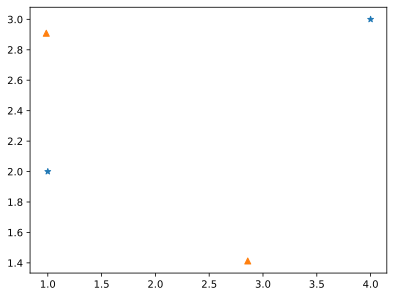

In [30]:
import matplotlib.pyplot as plt
if problem == 'repr':
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

for X_viz, y_viz in dataloader:
    x = X_viz.numpy()
    y = y_viz.numpy()
    plt.scatter(x[:,0], x[:,1], marker = '*')
    plt.scatter(y[:,0], y[:,1], marker = '^')
    plt.show()
    break

In [31]:
#Import of the model dynamics that describe the neural ODE
#The dynamics are based on the torchdiffeq package, that implements ODE solvers in the pytorch setting
from models.neural_odes import NeuralODE

#T is the end time of the neural ODE evolution, num_steps are the amount of discretization steps for the ODE solver
T, num_steps = 1, n_different_weights
bound = 0.
fp = False
cross_entropy = False
turnpike = False

# choice of model: what nonlinearity is used and if the nonlinearity is applied before (inside) or after (outside) the linear weights
# another choice is bottleneck, but I don't understand it
# non_linearity = 'tanh' # OR 'relu' 'sigmoid' 'leakyrelu' 'tanh_prime'
# architecture = 'inside' 'outside'
non_linearity = 'tanh'
architecture = 'restricted'
architectures = {'inside': -1, 'outside': 0, 'bottleneck': 1, 'restricted': 2}
# number of optimization runs in which the dataset is used for gradient decent
num_epochs = 50
if problem == 'moons' or problem == 'TS' or problem == "restrictedTS":
    hidden_dim, data_dim = 2, 2 
else:
    hidden_dim, data_dim = 3, 3 
augment_dim = 0


In [32]:
# resets the seed - allows for coherent runs in the gradient descent as well
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
anode = NeuralODE(device, data_dim, hidden_dim, output_dim=data_dim, augment_dim=augment_dim, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_anode = torch.optim.Adam(anode.parameters(), lr=1e-1) 

In [33]:
from models.training import doublebackTrainer

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
trainer_anode = doublebackTrainer(anode, optimizer_anode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps_comp = 0.2) 

In [34]:
trainer_anode.train(dataloader, 200)

Epoch 1: 9.991
Epoch 2: 9.924
Epoch 3: 9.710
Epoch 4: 9.095
Epoch 5: 7.611
Epoch 6: 5.417
Epoch 7: 3.941
Epoch 8: 3.088
Epoch 9: 2.030
Epoch 10: 0.813
Epoch 11: 0.271
Epoch 12: 0.503
Epoch 13: 0.809
Epoch 14: 0.965
Epoch 15: 1.009
Epoch 16: 1.001
Epoch 17: 0.973
Epoch 18: 0.946
Epoch 19: 0.932
Epoch 20: 0.930
Epoch 21: 0.927
Epoch 22: 0.897
Epoch 23: 0.814
Epoch 24: 0.681
Epoch 25: 0.526
Epoch 26: 0.382
Epoch 27: 0.266
Epoch 28: 0.179
Epoch 29: 0.120
Epoch 30: 0.130
Epoch 31: 0.135
Epoch 32: 0.157
Epoch 33: 0.182
Epoch 34: 0.209
Epoch 35: 0.216
Epoch 36: 0.209
Epoch 37: 0.188
Epoch 38: 0.155
Epoch 39: 0.129
Epoch 40: 0.124
Epoch 41: 0.152
Epoch 42: 0.163
Epoch 43: 0.137
Epoch 44: 0.102
Epoch 45: 0.099
Epoch 46: 0.113
Epoch 47: 0.121
Epoch 48: 0.113
Epoch 49: 0.093
Epoch 50: 0.074
Epoch 51: 0.079
Epoch 52: 0.091
Epoch 53: 0.083
Epoch 54: 0.065
Epoch 55: 0.062
Epoch 56: 0.069
Epoch 57: 0.070
Epoch 58: 0.061
Epoch 59: 0.048
Epoch 60: 0.048
Epoch 61: 0.050
Epoch 62: 0.048
Epoch 63: 0.042
E